In this notebook we identify excitatory connectivity parameters and input requirements that allow a saturated propagation of activity along a "1D" ridge of hyperexcitable CA3 pyramidal neurons.

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import interpolate, optimize

import aux
from ntwk import LIFNtwk, ridge_h, sample_vs_gs_init
from plot import raster, set_font_size
from traj import Traj, upstream_spks_from_traj

import PARAMETERS as P

cc = np.concatenate

## top level save directory
SAVE_DIR = 'sims/balance'

## excitation-only simulations
EXC_DIR = os.path.join(SAVE_DIR, 'exc')

EXC_PATH_TIME = os.path.join(EXC_DIR, 'time.npy')
EXC_PRFX_NTWK = os.path.join(EXC_DIR, 'ntwk')

# EC->PC weight dstr vs dst to rat pos
EXC_PATH_W_N_PC_EC_VS_DIST = os.path.join(EXC_DIR, 'w_n_pc_ec_vs_dist.npy')

# initial Vm and G_N dstrs for diff EC rates
EXC_PRFX_V_0_G_0_VS_EC_RT = os.path.join(EXC_DIR, 'v_0_g_0/ec_rt')

## inhibitory-only simulations
INH_DIR = os.path.join(SAVE_DIR, 'inh')

# HX PC Ridge

We first explore the properties of activity propagation along a ridge of hyperexcitable PCs, with recurrent excitation only and no inhibition.

### Determine expected EC->PC weight as a function of distance from ridge centerline

We do this by simulating the responses of a collection of PCs with place fields centered at different distances from the rat's current location. Afterwards, we measure the EC->PC weight as a function of these distances.

In [2]:
N = 200  # n nrns
DISTS = np.linspace(0, 0.2, N)  # dists to spread nrn place-field centers over (m)
DUR = 5  # sim duration
STIM_ITVL = (0, 2)  # stimulation itvl
N_TRIALS = 200

In [3]:
np.random.seed(0)

# build place fields
pfcs = np.array([DISTS, np.zeros(N)])  # centers
pfws = P.L_PL * np.ones(N)  # widths
max_rates = P.R_MAX_PL * np.ones(N)

# get place-tuned inputs
ts = np.arange(0, DUR, P.DT)
xys = np.zeros((len(ts), 2))
traj = Traj(ts=ts, xys=xys)

# build ntwk (N place inputs + N EC inputs)
ws_up = {
    'AMPA': cc([P.W_A_PC_PL * np.eye(N), np.zeros((N, N))], axis=1),
    'NMDA': cc([np.zeros((N, N)), P.W_N_PC_EC_I * np.eye(N)], axis=1),
}
ws_rcr = {
    'AMPA': np.zeros((N, N)),
    'NMDA': np.zeros((N, N)),
}
masks_plastic = {
    'AMPA': np.zeros(ws_up['AMPA'].shape, dtype=bool),
    'NMDA': cc([np.zeros((N, N)), np.eye(N)], axis=1).astype(bool),
}

ntwk = LIFNtwk(
    t_m=P.T_M_PC, e_l=P.E_L_PC, v_th=P.V_TH_PC, v_reset=P.V_RESET_PC, t_r=P.T_R,
    e_ahp=P.E_AHP, t_ahp=np.inf, w_ahp=0,
    es_syn={'AMPA': P.E_A, 'NMDA': P.E_N}, ts_syn={'AMPA': P.T_A, 'NMDA': P.T_N}, ws_up=ws_up, ws_rcr=ws_rcr,
    plasticity={
        'masks': masks_plastic,
        'w_ec_ca3_maxs': {'AMPA': np.nan, 'NMDA': P.W_N_PC_EC_F},
        'T_W': P.T_W, 'T_C': P.T_C, 'C_S': P.C_S, 'BETA_C': P.B_C,
    },
)

vs_init = np.repeat(P.E_L_PC, N)

ws_n_pc_ec = np.nan * np.zeros((N_TRIALS, N))

# run ntwk for n_trials
for ctr in range(N_TRIALS):
    if (ctr) % 10 == 0:
        print('Running simulations for trial {}/{} to {}/{}...'.format(
            ctr+1, N_TRIALS, min(ctr+10, N_TRIALS), N_TRIALS))
    spks_up_pl = upstream_spks_from_traj(ts, traj.xys, pfcs, pfws, max_rates)

    # set all upstream spikes outside of stimulation interval to 0
    mask = ~( (ts >= STIM_ITVL[0]) & (ts < STIM_ITVL[1]) )
    spks_up_pl[mask] = 0

    spks_up = np.zeros((len(ts), 2*N))
    spks_up[:, :N] = spks_up_pl

    rsp = ntwk.run(spks_up, dt=P.DT, vs_init=vs_init)
    ws_n_pc_ec[ctr, :] = rsp.ws_plastic['NMDA'][-1]

Running simulations for trial 1/200 to 10/200...
Running simulations for trial 11/200 to 20/200...
Running simulations for trial 21/200 to 30/200...
Running simulations for trial 31/200 to 40/200...
Running simulations for trial 41/200 to 50/200...
Running simulations for trial 51/200 to 60/200...
Running simulations for trial 61/200 to 70/200...
Running simulations for trial 71/200 to 80/200...
Running simulations for trial 81/200 to 90/200...
Running simulations for trial 91/200 to 100/200...
Running simulations for trial 101/200 to 110/200...
Running simulations for trial 111/200 to 120/200...
Running simulations for trial 121/200 to 130/200...
Running simulations for trial 131/200 to 140/200...
Running simulations for trial 141/200 to 150/200...
Running simulations for trial 151/200 to 160/200...
Running simulations for trial 161/200 to 170/200...
Running simulations for trial 171/200 to 180/200...
Running simulations for trial 181/200 to 190/200...
Running simulations for trial 19

In [4]:
# save weight values so that new ones can be quickly sampled later
print('Saving w_pc_ec vs. dist dstrs at "{}".'.format(
    aux.save(EXC_PATH_W_N_PC_EC_VS_DIST, {'dists': DISTS, 'ws_n_ec_pc': ws_n_pc_ec})))

Saving w_pc_ec vs. dist dstrs at "sims/balance/exc/w_n_pc_ec_vs_dist.npy".


### Create steady-state distribution of PC Vm and G_NMDA given EC inputs as fn of EC->PC cxn weight

To do this we simulate the response of each PC for a multi-second time period in response to EC inputs through an EC->PC synapse of specific cxn weight and then sample voltage-conductance pairs at multiple random time points within the multi-second period.

In [8]:
EC_RATES = np.arange(30, 61)  # different EC activation rates
N = 200  # number of PCs/different EC->PC weights
DUR = 21  # sim. duration
START = 1  # time to start measuring
N_SAMPLES = 1000  # num of time points to sample to build distribution

In [9]:
ws_n_pc_ec = np.linspace(P.W_N_PC_EC_I, P.W_N_PC_EC_F, N)

# build PC ntwk with these EC->PC cxn weights
ws_up = {'NMDA': np.diag(ws_n_pc_ec)}
ws_rcr = {'NMDA': np.zeros((N, N))}

ntwk = LIFNtwk(
    t_m=P.T_M_PC, e_l=P.E_L_PC, v_th=P.V_TH_PC, v_reset=P.V_RESET_PC, t_r=P.T_R,
    e_ahp=0, t_ahp=np.inf, w_ahp=0,
    es_syn={'NMDA': P.E_N}, ts_syn={'NMDA': P.T_N},
    ws_up=ws_up, ws_rcr=ws_rcr)

# loop over EC rates
ts = np.arange(0, DUR, P.DT)
vs_init = P.E_L_PC * np.ones(N)

for ec_rate in EC_RATES:
    print('Running simulation for EC rate: {} Hz...'.format(ec_rate))
    
    # build upstream (EC) spk input
    spks_up = np.random.poisson(P.DT*ec_rate, (len(ts), N))
    
    # run ntwk
    rsp = ntwk.run(spks_up, P.DT, vs_init)
    
    # randomly sample vs and conductances
    vs_sample = np.nan * np.zeros((N_SAMPLES, N))
    gs_sample = np.nan * np.zeros((N_SAMPLES, N))
    
    for nrn_ctr in range(N):
        # pick random time points to sample vs and gs at
        tps_sample = np.random.choice(np.arange(int(START/P.DT), int(DUR/P.DT)), N_SAMPLES)
        vs_sample[:, nrn_ctr] = rsp.vs[tps_sample, nrn_ctr]
        gs_sample[:, nrn_ctr] = rsp.gs['NMDA'][tps_sample, nrn_ctr]
        
    # save results
    aux.save(
        '{}_{}Hz.npy'.format(EXC_PRFX_V_0_G_0_VS_EC_RT, ec_rate),
        {'weights': ws_n_pc_ec, 'vs': vs_sample, 'gs': gs_sample})

Running simulation for EC rate: 30 Hz...
Running simulation for EC rate: 31 Hz...
Running simulation for EC rate: 32 Hz...
Running simulation for EC rate: 33 Hz...
Running simulation for EC rate: 34 Hz...
Running simulation for EC rate: 35 Hz...
Running simulation for EC rate: 36 Hz...
Running simulation for EC rate: 37 Hz...
Running simulation for EC rate: 38 Hz...
Running simulation for EC rate: 39 Hz...
Running simulation for EC rate: 40 Hz...
Running simulation for EC rate: 41 Hz...
Running simulation for EC rate: 42 Hz...
Running simulation for EC rate: 43 Hz...
Running simulation for EC rate: 44 Hz...
Running simulation for EC rate: 45 Hz...
Running simulation for EC rate: 46 Hz...
Running simulation for EC rate: 47 Hz...
Running simulation for EC rate: 48 Hz...
Running simulation for EC rate: 49 Hz...
Running simulation for EC rate: 50 Hz...
Running simulation for EC rate: 51 Hz...
Running simulation for EC rate: 52 Hz...
Running simulation for EC rate: 53 Hz...
Running simulati

### Show EC->PC weight, Vm, and G_NMDA distributions for one EC rate

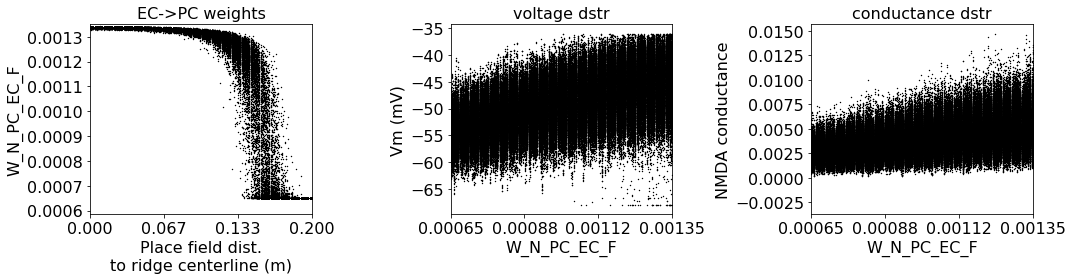

In [12]:
EC_RATE = 50

fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)

# plot final weight vs. distance
temp = aux.load(EXC_PATH_W_N_PC_EC_VS_DIST)
dists = temp['dists']
ws_n_pc_ec = temp['ws_n_ec_pc']

axs[0].scatter(np.tile(dists, (len(ws_n_pc_ec), 1)), ws_n_pc_ec, s=2, color='k', lw=0)
axs[0].set_xlim(dists[0], dists[-1])
axs[0].set_ylim(.9*P.W_N_PC_EC_I, P.W_N_PC_EC_F)
x_ticks = np.linspace(dists[0], dists[-1], 4)
x_tick_labels = ['{0:.3f}'.format(x_tick) for x_tick in x_ticks]

axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels(x_tick_labels)
axs[0].set_xlabel('Place field dist.\nto ridge centerline (m)')
axs[0].set_ylabel('W_N_PC_EC_F')
axs[0].set_title('EC->PC weights')

# plot v and g distribution vs. EC->PC weight
temp = aux.load('{}_{}Hz.npy'.format(EXC_PRFX_V_0_G_0_VS_EC_RT, EC_RATE))
ws_n_pc_ec = temp['weights']
vs = temp['vs']
gs = temp['gs']

for ctr, w in enumerate(ws_n_pc_ec):
    axs[1].scatter(w*np.ones(len(vs)), 1000* vs[:, ctr], s=2, c='k', lw=0)
    axs[2].scatter(w*np.ones(len(gs)), gs[:, ctr], s=2, c='k', lw=0)

x_ticks = np.linspace(P.W_N_PC_EC_I, P.W_N_PC_EC_F, 4)
x_tick_labels = ['{0:.5f}'.format(x_tick) for x_tick in x_ticks]

for ax in axs[1:]:
    ax.set_xlim(P.W_N_PC_EC_I, P.W_N_PC_EC_F)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)
    ax.set_xlabel('W_N_PC_EC_F')

axs[1].set_ylabel('Vm (mV)')
axs[1].set_title('voltage dstr')
axs[2].set_ylabel('NMDA conductance')
axs[2].set_title('conductance dstr')

for ax in axs:
    set_font_size(ax, 16)

### Construct example ridge

We now build a "horizontal" ridge using the above parameters that becomes HX in response to EC inputs.

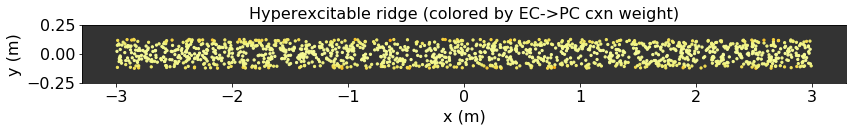

In [2]:
RIDGE_SHAPE = (6, 0.25)
PC_DENS = 1000

hx = aux.load(EXC_PATH_W_N_PC_EC_VS_DIST)

pfcs, ws_n_pc_ec = ridge_h(RIDGE_SHAPE, PC_DENS, hx)

fig, ax = plt.subplots(1, 1, figsize=(12, 3), tight_layout=True)
ax.set_facecolor((.2, .2, .2))
ax.scatter(pfcs[0], pfcs[1], s=5, c=ws_n_pc_ec, vmin=P.W_N_PC_EC_I, vmax=P.W_N_PC_EC_F, cmap='inferno')

ax.set_ylim(-RIDGE_SHAPE[1], RIDGE_SHAPE[1])
ax.set_aspect('equal')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Hyperexcitable ridge (colored by EC->PC cxn weight)')

set_font_size(ax, 16)

### Immediate ridge response to increasing PC activations

For different connectivity parameters we now simulate the response of the ridge to activating different numbers of initial PCs at the far left end of the ridge. Sufficiently strong responses ought to mean that if we let the simulation run longer we would see self-sustaining activity propagating along the ridge.

### Run ntwk

In [3]:
from itertools import product as cproduct
from ntwk import cxns_pcs_rcr

STIM = 0.01
DUR = .15
N_INITS = np.arange(4, 80, 2)
EC_RATE = 40

T_AHP = 0.05
W_AHP = 1

Z_PCS = np.arange(.2, 1, 0.05).round(2)
L_PCS = [.2]

N_TRIALS = 10
FAST_ITVL = [0.01, 0.012]
SLOW_ITVL = [0.02, 0.024]

EXAMPLES = [
    (3, 35, 0),  # zl_ctr, ni_ctr, tr_ctr
    (4, 13, 0),
    (4, 23, 0),
    (12, 18, 0),
]

SHOW_RASTERS = False

In [4]:
np.random.seed(0)

hx = aux.load(EXC_PATH_W_N_PC_EC_VS_DIST)
v_g_init = aux.load('{}_{}Hz.npy'.format(EXC_PRFX_V_0_G_0_VS_EC_RT, EC_RATE))
ts = np.arange(0, DUR, P.DT)
aux.save_time_file(EXC_PATH_TIME, ts)

zs_ls = list(cproduct(Z_PCS, L_PCS))
summed_spikes = np.nan * np.zeros((len(zs_ls), len(N_INITS), N_TRIALS, len(ts)))

fast_rsps = np.nan * np.zeros((len(zs_ls), len(N_INITS), N_TRIALS))
slow_rsps = np.nan * np.zeros((len(zs_ls), len(N_INITS), N_TRIALS))

xmpl_paths = []

for zl_ctr, (z_pc, l_pc) in enumerate(zs_ls):
    print('Running simulations for z_pc = {}, l_pc = {}:'.format(z_pc, l_pc))
    
    for tr_ctr in range(N_TRIALS):
        print('Running trial {}/{}...'.format(tr_ctr+1, N_TRIALS))
        
        # make ridge
        pfcs, ws_n_pc_ec = ridge_h(RIDGE_SHAPE, PC_DENS, hx)
        n = pfcs.shape[1]

        # sort nrns by distance to left-most point on ridge, which is
        # the order they'll be recruited into the initial stim
        dx = pfcs[0] + (RIDGE_SHAPE[0]/2)
        dy = pfcs[1]
        
        rcrt_order = np.argsort(np.sqrt(dx**2 + dy**2))
        
        # sort nrns by x-coordinate
        x_order = np.argsort(pfcs[0])
        
        # make upstream connectivity matrix
        ws_up_a = P.W_A_PC_PL * np.eye(n)
        ws_up_n = np.diag(ws_n_pc_ec)
        ws_up = {
            'AMPA': cc([ws_up_a, np.zeros((n, n))], axis=1),
            'NMDA': cc([np.zeros((n, n)), ws_up_n], axis=1),
        }

        # make recurrent connectivity matrix
        cxns = cxns_pcs_rcr(pfcs, z_pc, l_pc)
        ws_rcr = {'AMPA': P.W_A_PC_PC*cxns.astype(float), 'NMDA': np.zeros((n, n))}

        # make ntwk
        ntwk = LIFNtwk(
            t_m=P.T_M_PC, e_l=P.E_L_PC, v_th=P.V_TH_PC,
            v_reset=P.V_RESET_PC, t_r=P.T_R,
            e_ahp=P.E_AHP, t_ahp=T_AHP, w_ahp=W_AHP,
            es_syn={'AMPA': P.E_A, 'NMDA': P.E_N},
            ts_syn={'AMPA': P.T_A, 'NMDA': P.T_N},
            ws_up=ws_up, ws_rcr=ws_rcr)

        # sample initial voltages and NMDA conductances
        vs_init, gs_init = sample_vs_gs_init(ws_n_pc_ec, v_g_init)
        gs_init['AMPA'] = np.zeros(n)
        
        # loop over numbers of PCs to initially stimulate
        if SHOW_RASTERS:
            fig_size = (15, 4*len(N_INITS))
            fig, axs = plt.subplots(len(N_INITS), 1, figsize=fig_size, tight_layout=True, squeeze=False)
        
        for ni_ctr, n_init in enumerate(N_INITS):
            
            # build initial upstream place-tuned input spk array
            spks_up = np.zeros((len(ts), 2*n))
            spks_up[int(STIM/P.DT), rcrt_order[:n_init]] = P.U_A_PC
            
            # add in EC inputs
            spks_up_ec = np.random.poisson(EC_RATE*P.DT, (len(ts), n))
            spks_up[:, n:] = spks_up_ec
            
            # run ntwk
            rsp = ntwk.run(spks_up, P.DT, vs_init=vs_init, gs_init=gs_init)
            
            if SHOW_RASTERS:
                ax = axs[ni_ctr, 0]
                raster(ax, ts, rsp.spks, order=x_order, lw=1)
                title = 'Z_PC = {}, L_PC = {}, TRIAL {}, N_INIT = {}'.format(
                    z_pc, l_pc, tr_ctr+1, n_init)
                ax.set_title(title)
                set_font_size(ax, 16)
                
            # store results
            summed_spikes[zl_ctr, ni_ctr, tr_ctr, :] = rsp.spks.sum(1)
            
            fast_rsps[zl_ctr, ni_ctr, tr_ctr] = \
                rsp.spks.sum(1)[(FAST_ITVL[0] <= ts)&(ts < FAST_ITVL[1])].mean()
                
            slow_rsps[zl_ctr, ni_ctr, tr_ctr] = \
                rsp.spks.sum(1)[(SLOW_ITVL[0] <= ts)&(ts < SLOW_ITVL[1])].mean()

            for xmpl in EXAMPLES:
                if (zl_ctr, ni_ctr, tr_ctr) == xmpl:
                    
                    rsp.place_field_centers = pfcs
                    
                    xmpl_path = '{}_Z_PC_{}_L_PC_{}_N_INIT_{}_TR_{}.npy'.format(
                        EXC_PRFX_NTWK, z_pc, l_pc, n_init, tr_ctr+1)
                    
                    xmpl_paths.append(rsp.save(xmpl_path))
                    
                    break

Running simulations for z_pc = 0.2, l_pc = 0.2:
Running trial 1/10...
Running trial 2/10...
Running trial 3/10...
Running trial 4/10...
Running trial 5/10...
Running trial 6/10...
Running trial 7/10...
Running trial 8/10...
Running trial 9/10...
Running trial 10/10...
Running simulations for z_pc = 0.25, l_pc = 0.2:
Running trial 1/10...
Running trial 2/10...
Running trial 3/10...
Running trial 4/10...
Running trial 5/10...
Running trial 6/10...
Running trial 7/10...
Running trial 8/10...
Running trial 9/10...
Running trial 10/10...
Running simulations for z_pc = 0.3, l_pc = 0.2:
Running trial 1/10...
Running trial 2/10...
Running trial 3/10...
Running trial 4/10...
Running trial 5/10...
Running trial 6/10...
Running trial 7/10...
Running trial 8/10...
Running trial 9/10...
Running trial 10/10...
Running simulations for z_pc = 0.35, l_pc = 0.2:
Running trial 1/10...
Running trial 2/10...
Running trial 3/10...
Running trial 4/10...
Running trial 5/10...
Running trial 6/10...
Running tri

### Summed population activity plots

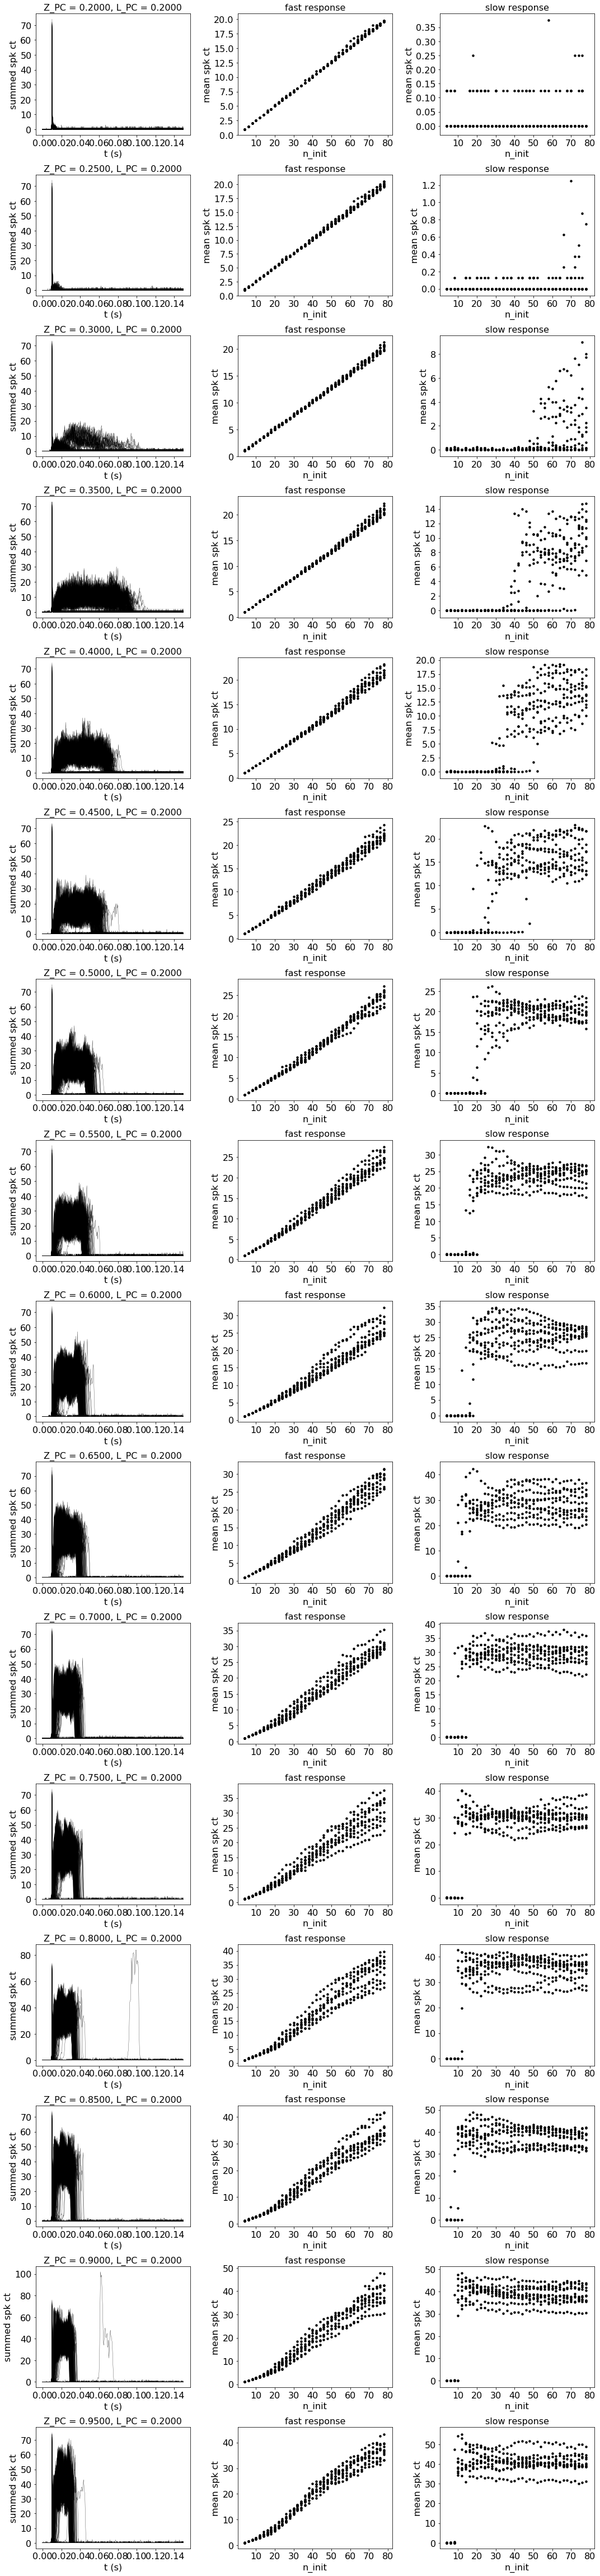

In [5]:
n_rows = len(zs_ls)
fig_size = (15, n_rows*4)

fig, axs = plt.subplots(n_rows, 3, figsize=fig_size, tight_layout=True, squeeze=False)

for zl_ctr, ax_row in enumerate(axs):
    # loop over all n_inits and trials
    for ni_ctr, n_init in enumerate(N_INITS):
        for tr_ctr in range(N_TRIALS):
            ax_row[0].plot(ts, summed_spikes[zl_ctr, ni_ctr, tr_ctr], color='k', lw=0.3)
        
        fast_rsps_ = fast_rsps[zl_ctr, ni_ctr]
        slow_rsps_ = slow_rsps[zl_ctr, ni_ctr]
        
        n_inits_ = n_init*np.ones(N_TRIALS)
        
        ax_row[1].scatter(n_inits_, fast_rsps_, s=20, c='k', lw=0)
        ax_row[2].scatter(n_inits_, slow_rsps_, s=20, c='k', lw=0)
        
    ax_row[0].set_xlabel('t (s)')
    ax_row[0].set_ylabel('summed spk ct')
    ax_row[0].set_title('Z_PC = {0:.4f}, L_PC = {1:.4f}'.format(*zs_ls[zl_ctr]))
    
    ax_row[1].set_xlabel('n_init')
    ax_row[1].set_ylabel('mean spk ct')
    ax_row[1].set_title('fast response')
    
    ax_row[2].set_xlabel('n_init')
    ax_row[2].set_ylabel('mean spk ct')
    ax_row[2].set_title('slow response')
    
for ax in axs.flat:
    set_font_size(ax, 16)

### Animate example trials

In [6]:
from anim import build_frames

frames = []

for xp_ctr, xmpl_path in enumerate(xmpl_paths):
    
    z_pc, l_pc = zs_ls[EXAMPLES[xp_ctr][0]]
    n_init = N_INITS[EXAMPLES[xp_ctr][1]]
    tr_ctr = EXAMPLES[xp_ctr][2]+1
    
    save_prefix = os.path.join(
        EXC_DIR, 'ntwk', 'Z_PC_{}_L_PC_{}_N_INIT_{}_TR_{}/frame'.format(
            z_pc, l_pc, n_init, tr_ctr))
    
    positions = aux.load(xmpl_path)['place_field_centers']
    
    frames.append(build_frames.ntwk_activity(
        save_prefix=save_prefix,
        time_file=EXC_PATH_TIME,
        ntwk_file=xmpl_path,
        fps=500,
        box=[-3.1, 3.1, -0.4, 0.4],
        resting_size=30,
        spk_size=400,
        amp=3,
        positions=positions,
        default_color='k',
        cxn_color='k',
        cxn_lw=.1,
        frames_per_spk=2,
        title='Network activity',
        x_label='x (m)',
        y_label='y (m)',
        fig_size=(15, 4),
        verbose=True))

Using timestamp file "sims/balance/exc/time.npy" and activity file "sims/balance/exc/ntwk_Z_PC_0.35_L_PC_0.2_N_INIT_74_TR_1.npy".
Frames will be saved with prefix "sims/balance/exc/ntwk/Z_PC_0.35_L_PC_0.2_N_INIT_74_TR_1/frame".
Loading timestamps and network activity data...
Downsampling data from 2000.0 Hz to 500 fps...
Data downsampled.
Data loaded.
Generating and saving 75 frames...
43 frames completed after 30.577 s...
All frames written to disk.
Using timestamp file "sims/balance/exc/time.npy" and activity file "sims/balance/exc/ntwk_Z_PC_0.4_L_PC_0.2_N_INIT_30_TR_1.npy".
Frames will be saved with prefix "sims/balance/exc/ntwk/Z_PC_0.4_L_PC_0.2_N_INIT_30_TR_1/frame".
Loading timestamps and network activity data...
Downsampling data from 2000.0 Hz to 500 fps...
Data downsampled.
Data loaded.
Generating and saving 75 frames...
38 frames completed after 30.116 s...
All frames written to disk.
Using timestamp file "sims/balance/exc/time.npy" and activity file "sims/balance/exc/ntwk_Z_

In [7]:
from anim import create_mp4

for frames_, xmpl in zip(frames, EXAMPLES):
    
    z_pc, l_pc = zs_ls[xmpl[0]]
    n_init = N_INITS[xmpl[1]]
    tr_ctr = xmpl[2]+1
    
    save_path = os.path.join(
        EXC_DIR, 'ntwk', 'Z_PC_{}_L_PC_{}_N_INIT_{}_TR_{}'.format(
            z_pc, l_pc, n_init, tr_ctr))
    movie = create_mp4(
        frames_, save_path, playback_fps=30, verbose=True)

Loading source images...


Source images loaded.
Generating movie and saving at "sims/balance/exc/ntwk/Z_PC_0.35_L_PC_0.2_N_INIT_74_TR_1.mp4"...
Movie generated.
Loading source images...


Source images loaded.
Generating movie and saving at "sims/balance/exc/ntwk/Z_PC_0.4_L_PC_0.2_N_INIT_30_TR_1.mp4"...
Movie generated.
Loading source images...


Source images loaded.
Generating movie and saving at "sims/balance/exc/ntwk/Z_PC_0.4_L_PC_0.2_N_INIT_50_TR_1.mp4"...
Movie generated.
Loading source images...


Source images loaded.
Generating movie and saving at "sims/balance/exc/ntwk/Z_PC_0.8_L_PC_0.2_N_INIT_40_TR_1.mp4"...
Movie generated.
